# **Modelo analítico para la campaña de tarjeta adicional con Python**

## 1. Carga de fuentes de información
### _El objetivo de esta sección es cargar los datos en el notebook y visualizar las características de las variables_

In [1]:
# Importar la librería pandas para la carga y entendimiento de la fuente de información. Adicionalmente importa
# la librería Mathplotlib para realizar gráficas en caso de que se requiera, así como la librería numpy para convertir
# las fuentes de datos en arreglos 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Se modifica el formato en el que se muestra la información con esta librería para evitar salidas en notación científica
pd.options.display.float_format = '{:20,.2f}'.format

# Se lee el archivo fuente y se guarda en la variable arch_fuente
arch_fuente = pd.read_excel('./ADICIONALES MUESTRA ALEATORIA.xlsx',sheet_name='ADICIONALES MUESTRA ALEATORIA S')

# Tipos de datos
tipos_datos = arch_fuente.dtypes
print(tipos_datos)


ID                     int64
INGRESOS             float64
EDAD                 float64
GENERO                object
ESTRATO              float64
NO_PERSONAS_CARGO    float64
DEPTO_RESIDENCIA      object
EST_CIVIL             object
TIENE_ADICIONAL      float64
Unnamed: 9           float64
Unnamed: 10          float64
dtype: object


## 2. Entendimiento de la data histórica y transformaciones
### _El objetivo de esta sección es tener un entendimiento del set de datos y realizar las transformaciones necesarias para que los datos puedan utilizarse como soporte a las decisiones de la nueva campaña del Banco Falabella_

In [2]:
# Se identificaron dos columnas que no corresponden al set de datos por lo cual se eliminan
del arch_fuente['Unnamed: 9']
del arch_fuente['Unnamed: 10']

In [3]:
# Se identifica si se encuentran valores faltantes.
arch_fuente.isnull().sum()

ID                       0
INGRESOS               203
EDAD                   250
GENERO                 256
ESTRATO               3105
NO_PERSONAS_CARGO      203
DEPTO_RESIDENCIA       362
EST_CIVIL              256
TIENE_ADICIONAL      25000
dtype: int64

In [4]:
# Se eliminan los registros que tengan faltantes que no se puedan determinar mediante otros registros
#como son el caso del género, el estado civil, los ingresos y la edad
arch_fuente = arch_fuente.dropna(subset=(['INGRESOS','EDAD','GENERO','NO_PERSONAS_CARGO','DEPTO_RESIDENCIA','EST_CIVIL']))

# Se vuelven a validar los valores faltantes.
arch_fuente.isnull().sum()


ID                       0
INGRESOS                 0
EDAD                     0
GENERO                   0
ESTRATO               2728
NO_PERSONAS_CARGO        0
DEPTO_RESIDENCIA         0
EST_CIVIL                0
TIENE_ADICIONAL      24808
dtype: int64

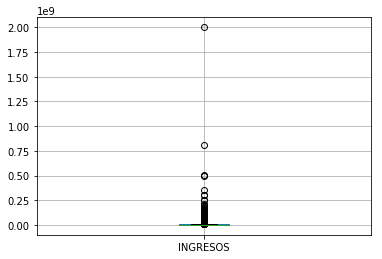

In [5]:
# Se grafican los boxplot como apoyo para la toma de decisiones respecto al manejo de los valores atípicos para las
# variables que se muestran a continuación:

arch_fuente.boxplot(column=['INGRESOS'])

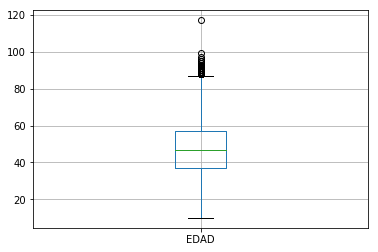

In [6]:
arch_fuente.boxplot(column=['EDAD'])

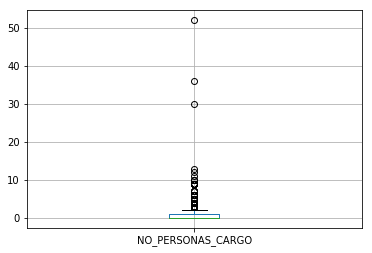

In [7]:
arch_fuente.boxplot(column=['NO_PERSONAS_CARGO'])

In [8]:
# Supuesto 1: Al identificar registros con ingresos atípicos por el valor del salario mínimo legal vigente en Colombia,
# a criterio de invalidez de estos datos para el modelo, se decide eliminar estos registros debido a que pueden llevar
# a tomar decisiones equivocadas.

arch_fuente = arch_fuente.drop(arch_fuente[arch_fuente.INGRESOS < 150000].index)

# Supuesto 2: Al identificar registros con cantidad de personas a cargo atípico como es el caso de los valores que 
# son mayores de 20, se eliminan estos registros para el modelo dedibo a que pueden llevar a tomar decisiones
# equivocadas.

arch_fuente = arch_fuente.drop(arch_fuente[arch_fuente.NO_PERSONAS_CARGO > 20].index)

# Supuesto 3: Considerando la imposibilidad del negocio para ofrecer productos financieros a menores de edad directamente, 
# se decide eliminar los registros con valores menores a 18 años así como los que superan los 95 años por restricción
# biológica ya que los valores superiores pueden corresponder a hallazgos de calidad de datos

arch_fuente = arch_fuente.drop(arch_fuente[arch_fuente.EDAD < 18].index)
arch_fuente = arch_fuente.drop(arch_fuente[arch_fuente.EDAD > 95].index)

In [9]:
# Supuesto 4: Se asume que para calcular los ingresos promedio por departamento y estrato
# se cuenta con toda la base de información (tanto la histórica, como la que se quiere utilizar
# para ofrecer la tarjeta adicional).

# Se obtiene el promedio de ingresos por estrato y por departamento de residencia para poder calcular
# el estrato de los registros con missing values.
estim_estrato = arch_fuente.groupby(['DEPTO_RESIDENCIA','ESTRATO'],as_index=False).mean()

print(estim_estrato)

# Se extraen los registros que tienen el estrato faltante 
estr_faltante = arch_fuente[arch_fuente.ESTRATO.isnull()]

# Se eliminan los registros con estrato faltante para evitar la duplicidad de datos más adelante ya que estros
# ya se encuentran en el data frame estr_faltante
arch_fuente = arch_fuente.dropna(subset=(['ESTRATO']))

    DEPTO_RESIDENCIA              ESTRATO                   ID  \
0           AMAZONAS                 3.00         3,934,545.50   
1           AMAZONAS                 4.00         4,869,187.00   
2           AMAZONAS                 5.00         3,449,613.00   
3          ANTIOQUIA                 1.00         5,031,497.45   
4          ANTIOQUIA                 2.00         4,554,765.99   
5          ANTIOQUIA                 3.00         5,000,367.27   
6          ANTIOQUIA                 4.00         4,940,630.59   
7          ANTIOQUIA                 5.00         4,879,365.82   
8          ANTIOQUIA                 6.00         5,162,152.01   
9             ARAUCA                 2.00         1,492,045.50   
10            ARAUCA                 3.00         4,559,744.09   
11            ARAUCA                 4.00         5,108,775.33   
12            ARAUCA                 5.00         4,874,829.50   
13            ARAUCA                 6.00         3,923,322.00   
14        

In [10]:
# Se hace una iteración en los registros con estrato faltante y con la información de ingreso promedio
# agrupada por departamento y por estrato se identifica cual es el estrato con menor diferencia para ese
# nivel de ingresos en el departamento

estr_calculados = pd.DataFrame(columns=['ID','INGRESOS','EDAD','GENERO','ESTRATO','NO_PERSONAS_CARGO','DEPTO_RESIDENCIA','EST_CIVIL','TIENE_ADICIONAL'])

i = 0
for indiceF, filaF in estr_faltante.iterrows():
    incomeF = filaF['INGRESOS']
    deptF = filaF['DEPTO_RESIDENCIA']
    minDif = 100000000000
    estrato = 10
    
    for indiceE, filaE in estim_estrato.iterrows():           
        incomeE = filaE['INGRESOS']
        estE = filaE['ESTRATO']
        deptE = filaE['DEPTO_RESIDENCIA']
        
        if deptE == deptF and abs(incomeE - incomeF) < minDif:
                minDif = abs(incomeE - incomeF)
                estrato = estE
        
    if estrato != 10:
        estr_calculados.loc[i] = [filaF['ID'],filaF['INGRESOS'],filaF['EDAD'],filaF['GENERO'],estrato,filaF['NO_PERSONAS_CARGO'],filaF['DEPTO_RESIDENCIA'],filaF['EST_CIVIL'],filaF['TIENE_ADICIONAL']]
        i = i+1
        

In [11]:
# Concatena los dos Data Frame, el primero que tiene los datos con estrato desde la fuente y 
# el segundo que tiene los datos con estrato calculado con base en el código anterior.

arch_fuente = pd.concat([arch_fuente, estr_calculados])

In [12]:
# Las variables categóricas deben ser transformadas a dummies antes de utilizarse en un modelo analítico
# de clasificación binaria con la variable objetivo tiene adicional

arch_fuente = pd.get_dummies(arch_fuente, columns=['GENERO','DEPTO_RESIDENCIA','EST_CIVIL'])


In [13]:
# Se selecciona solamente la data histórica para el entrenamiento del modelo, es decir la data donde la variable
# TIENE_ADICIONAL no es null
dataset_train = arch_fuente.dropna(subset=['TIENE_ADICIONAL'])

dataset_train = dataset_train.drop('ID', axis = 1)

# Se selecciona solamente la data sobre la cual se va a probar el modelo después de entrenar y evaluar el modelo con la
# data histórica
dataset_pred = arch_fuente[arch_fuente.TIENE_ADICIONAL.isnull()]


In [14]:
# Se visualizan las estadisticas descriptivas de las variables numéricas del set de datos
descriptivas = dataset_train.describe()
print(descriptivas)


                  INGRESOS                 EDAD              ESTRATO  \
count            24,531.00            24,531.00            24,531.00   
mean          4,522,681.78                47.90                 3.51   
std           9,037,036.30                12.84                 1.09   
min             150,000.00                19.00                 1.00   
25%           2,000,000.00                38.00                 3.00   
50%           3,000,000.00                47.00                 3.00   
75%           5,000,000.00                57.00                 4.00   
max         807,000,000.00                95.00                 6.00   

         NO_PERSONAS_CARGO      TIENE_ADICIONAL      GENERO_FEMENINO  \
count            24,531.00            24,531.00            24,531.00   
mean                  0.58                 0.17                 0.49   
std                   0.89                 0.37                 0.50   
min                   0.00                 0.00                

TIENE_ADICIONAL
0.00    20400
1.00     4131
dtype: int64


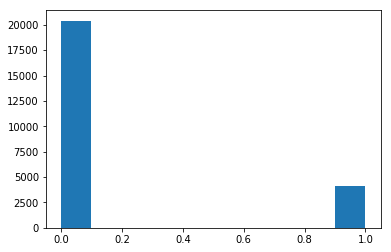

In [15]:
# Se realiza un recuento de las ocurrencias de la variable objetivo para el modelo TIENE_ADICIONAL
# Se puede visualizar que durante el modelado es necesario tener en cuenta el oversampling para lo cual es necesario
# realizar unos ajustes al set de entrenamiento

clasesTieneAdicional = dataset_train.groupby('TIENE_ADICIONAL').size()
print(clasesTieneAdicional)

plt.hist(dataset_train['TIENE_ADICIONAL'])
plt.show()

## 3. Modelado
### _El objetivo de esta sección es entrenar y evaluar el modelo analítico que en este caso se va a probar con un random forest classifier_

In [16]:
# Se importan las librerías para utilizar el modelo Random Forest para una variable objetivo binaria, la librería
# que permite hacer el split de los datos para el set de prueba y de evaluación, las de las métricas del modelo y
# la librería que permite dar un manejo al over-sampling con el algoritmo SMOTE.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Se dividen los sets de datos de entrenamiento y con un 80% y 20% respectivamente 
train_x, eval_x, \
train_y, eval_y, = train_test_split(dataset_train.drop(['TIENE_ADICIONAL'], axis=1),
                                               dataset_train['TIENE_ADICIONAL'],
                                               test_size = .2,
                                               random_state=19)

In [17]:
# Se utiliza el algoritmo SMOTE para manejar el oversampling
# Los sets de entrenamiento se ajustan para poder tomar decisiones de manera adecuada con la información disponible.

sm = SMOTE(random_state=19, ratio = 1.0)
train_x_sm, train_y_sm = sm.fit_sample(train_x, train_y)

In [18]:
# Una vez modificados los sets de entrenamiento para manejar el oversampling se procede a entrenar el modelo analítico

rf = RandomForestClassifier(n_estimators = 100, random_state = 19)
rf.fit(train_x_sm, train_y_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=19, verbose=0, warm_start=False)

## 4. Evaluación y análisis de resultados
### _El objetivo de esta sección es evaluar el modelo entrenado con los datos de prueba y analizar los resultados obtenidos_

In [19]:
# Predecir los datos de prueba con el modelo entrenado
predicciones = rf.predict(eval_x)

# Se obtienen dos métricas con base en las predicciones
print('Precisión y matriz de confusión:', accuracy_score(predicciones,eval_y))
print(confusion_matrix(predicciones,eval_y))

# Se presenta un modelo con un 81% de precisión de los datos evaluados. 


Precisión y matriz de confusión: 0.7923374770735684
[[3809  758]
 [ 261   79]]


In [20]:
# A continuación se van a análizar cuales son las variables mas importantes para explicar el motivo por el cual un cliente
# adquiere una tarjeta adicional o no.

# Computar las importancias de las distintas variables en el arbol
importancias = list(rf.feature_importances_)

# Tuplas de variables e importancia de las mismas
lista_variables = dataset_train.drop(['TIENE_ADICIONAL'], axis=1)

feature_importances = [(feature, round(importance,2))for feature, importance in zip(lista_variables, importancias)] 

# Ordenar las tuplas por importancia
feature_importances = sorted(feature_importances, key = lambda x:x[1], reverse = True)

# Mostrar las importancias
[print ('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances];

# En esta salida se evidencia la importancia de los ingresos y edad de una persona para que acepten o no acepten 
# adquirir una nueva tarjeta de crédito

Variable: INGRESOS   Importance: 0.15
Variable: EDAD       Importance: 0.14
Variable: EST_CIVIL_CASADO/A Importance: 0.09
Variable: ESTRATO    Importance: 0.08
Variable: NO_PERSONAS_CARGO Importance: 0.08
Variable: EST_CIVIL_SOLTERO/A Importance: 0.08
Variable: GENERO_FEMENINO Importance: 0.07
Variable: GENERO_MASCULINO Importance: 0.07
Variable: DEPTO_RESIDENCIA_CUNDINAMARCA Importance: 0.07
Variable: DEPTO_RESIDENCIA_ANTIOQUIA Importance: 0.04
Variable: DEPTO_RESIDENCIA_VALLE DEL CAUCA Importance: 0.03
Variable: EST_CIVIL_UNION LIBRE Importance: 0.03
Variable: DEPTO_RESIDENCIA_ATLANTICO Importance: 0.01
Variable: DEPTO_RESIDENCIA_BOLIVAR Importance: 0.01
Variable: DEPTO_RESIDENCIA_RISARALDA Importance: 0.01
Variable: DEPTO_RESIDENCIA_SANTANDER Importance: 0.01
Variable: DEPTO_RESIDENCIA_TOLIMA Importance: 0.01
Variable: EST_CIVIL_DIVORCIADO/SEPARADO Importance: 0.01
Variable: DEPTO_RESIDENCIA_AMAZONAS Importance: 0.0
Variable: DEPTO_RESIDENCIA_ARAUCA Importance: 0.0
Variable: DEPTO_R

In [21]:
# Se guarda una columna con los ID de usuarios que se va a predecir la probabilidad de que adquieran un producto
# determinado.
ids = np.array(dataset_pred['ID'])

# se van a eliminar las columnas que no hacen parte del modelo predictivo
del dataset_pred['TIENE_ADICIONAL']
del dataset_pred['ID']

In [22]:
# Se guardan las probabilidades de que las observaciones del set de datos a predecir adquieran
# los nuevos productos del Banco Falabella

probabilidades = rf.predict_proba(dataset_pred)
probabilidades = probabilidades[:,1]

In [23]:
# Se hace un producto cruz entre los identificadores y las probabilidades
probaCliente = np.vstack([ids,probabilidades]).T


In [24]:
# Obtener los 500 clientes con mayor probabilidad de obtener una tarjeta.
probaCliente2 = probaCliente[probaCliente[:,1].argsort()[::-1][:5000]]
print(probaCliente2)

[[5126911 0.98]
 [5081716 0.98]
 [8159634 0.97]
 ...
 [8694728 0.3]
 [6397019 0.3]
 [5186500 0.3]]


In [25]:
# Trae a los 5000 id que se deberían guardar
personas = pd.DataFrame(probaCliente2[:,0])

# Se exporta a Excel los 500 personas que se deberían llamar de acuerdo con las probabilidades
personas.to_excel("salida.xlsx")